In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle
import joblib
import csv

from tqdm.notebook import tqdm, trange

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from rdkit import Chem
from rdkit.Chem import AllChem

## Load Dataset

In [2]:
data_path = 'dataset/train_data_fix_concat.csv'
data_df = pd.read_csv(data_path)

In [3]:
target_oil_property = 'ad7e6027-00b8-4c27-918c-d1561f949ad8'

In [4]:
data_df.head()

,oil_type,blend_id,oil_property_param_title,oil_property_param_value,component_name,component_class,polymer,component_property_param_title,component_property_param_value,smiles
0,3fa07e0a-415c-496d-b88b-557855cb3e77,49743a76-a614-11ee-9529-005056921581,4c7a51f1-dc82-41dc-92fa-772535c2c70c,15.58,615537f6-1f8f-4240-a5e9-8f7be344ecd3,Group 1 base oil,no,02236ee6-5eec-4368-a2e4-6f2e73fb0f96,0.0000,CCCCC
1,3fa07e0a-415c-496d-b88b-557855cb3e77,49743a76-a614-11ee-9529-005056921581,4c7a51f1-dc82-41dc-92fa-772535c2c70c,15.58,615537f6-1f8f-4240-a5e9-8f7be344ecd3,Group 1 base oil,no,2511714c-ab50-4566-bc92-8e4095d87d01,0.0000,CCCCC
2,3fa07e0a-415c-496d-b88b-557855cb3e77,49743a76-a614-11ee-9529-005056921581,4c7a51f1-dc82-41dc-92fa-772535c2c70c,15.58,615537f6-1f8f-4240-a5e9-8f7be344ecd3,Group 1 base oil,no,38b06d9a-bcf2-40de-8e1b-9c3988c42406,0.0001,CCCCC
3,3fa07e0a-415c-496d-b88b-557855cb3e77,49743a76-a614-11ee-9529-005056921581,4c7a51f1-dc82-41dc-92fa-772535c2c70c,15.58,615537f6-1f8f-4240-a5e9-8f7be344ecd3,Group 1 base oil,no,f216a0c7-d453-4b15-9b4a-7647cbe2d874,0.0990,CCCCC
4,3fa07e0a-415c-496d-b88b-557855cb3e77,49743a76-a614-11ee-9529-005056921581,4c7a51f1-dc82-41dc-92fa-772535c2c70c,15.58,615537f6-1f8f-4240-a5e9-8f7be344ecd3,Group 1 base oil,no,9703e283-f529-4fdb-8d84-24413b2b4338,0.0001,CCCCC


## Remove Dublicates

In [5]:
len(data_df)

361981

In [6]:
data_df.drop_duplicates(inplace=True)
len(data_df)

323906

In [7]:
# For oil properties that have multiple different values (for one blend), we use the median value

count_unique = data_df[np.isfinite(data_df.oil_property_param_value)].groupby(['blend_id', 'oil_property_param_title']).oil_property_param_value.unique().map(len)
multiindex = count_unique[count_unique>1].index

for idx in tqdm(multiindex):
    vals = data_df[np.isfinite(data_df.oil_property_param_value) & (data_df.blend_id == idx[0]) & (data_df.oil_property_param_title == idx[1])].oil_property_param_value
    newval = np.median(vals)
    data_df.loc[(data_df.blend_id == idx[0]) & (data_df.oil_property_param_title == idx[1]) & (data_df.oil_property_param_value != newval), 'oil_property_param_value'] = newval  

data_df.drop_duplicates(inplace=True)
len(data_df)

  0%|          | 0/31 [00:00<?, ?it/s]

321421

In [8]:
# For component properties that have multiple different values (for one blend), we use the median value

count_unique = data_df[np.isfinite(data_df.component_property_param_value)].groupby(['blend_id', 'oil_property_param_title', 'component_name', 'component_property_param_title']).component_property_param_value.unique().map(len)
multiindex = count_unique[count_unique>1].index

for idx in tqdm(multiindex):
    vals = data_df[np.isfinite(data_df.component_property_param_value) & (data_df.blend_id == idx[0]) & (data_df.oil_property_param_title == idx[1])
                        & (data_df.component_name == idx[2]) & (data_df.component_property_param_title == idx[3])].component_property_param_value
    newval = np.median(vals)
    data_df.loc[(data_df.blend_id == idx[0]) & (data_df.oil_property_param_title == idx[1])
                        & (data_df.component_name == idx[2]) & (data_df.component_property_param_title == idx[3]) 
                        & (data_df.component_property_param_value != newval), 'component_property_param_value'] = newval

data_df.drop_duplicates(inplace=True)
len(data_df)

  0%|          | 0/320 [00:00<?, ?it/s]

321101

In [9]:
# For component properties that have both a value and NaN (for one blend), we take the non-NaN value

count_unique = data_df.groupby(['blend_id', 'oil_property_param_title', 'component_name', 'component_property_param_title']).component_property_param_value.unique().map(len)
multiindex = count_unique[count_unique>1].index

for idx in tqdm(multiindex):
    newval = data_df[np.isfinite(data_df.component_property_param_value) & (data_df.blend_id == idx[0]) & (data_df.oil_property_param_title == idx[1])
                        & (data_df.component_name == idx[2]) & (data_df.component_property_param_title == idx[3])].component_property_param_value.mean()
    
    data_df.loc[(data_df.blend_id == idx[0]) & (data_df.oil_property_param_title == idx[1])
                        & (data_df.component_name == idx[2]) & (data_df.component_property_param_title == idx[3]) 
                        & (data_df.component_property_param_value != newval), 'component_property_param_value'] = newval

data_df.drop_duplicates(inplace=True)
len(data_df)

  0%|          | 0/4272 [00:00<?, ?it/s]

316829

## Dataset Analysis

In [11]:
print(f'Number of blends: {len(data_df.blend_id.unique())}')
print(f'Number of smiles: {len(data_df.smiles.unique())}')
print(f'Number of components and its types: {len(data_df.component_name.unique())}, {len(data_df.component_class.unique())}')
print(f'Number of oil types: {len(data_df.oil_type.unique())}')
print(f'Number of oil property params: {len(data_df.oil_property_param_title.unique())}')
print(f'Number of component property params: {len(data_df.component_property_param_title.unique())}')

Number of blends: 348
Number of smiles: 52
Number of components and its types: 112, 14
Number of oil types: 5
Number of oil property params: 104
Number of component property params: 63


In [12]:
data_df.isnull().any()

oil_type                           True
blend_id                          False
oil_property_param_title          False
oil_property_param_value           True
component_name                    False
component_class                    True
polymer                            True
component_property_param_title    False
component_property_param_value     True
smiles                             True
dtype: bool

### Target Distribution by Oil Type

In [13]:
oil_types = data_df.oil_type.unique()

In [14]:
data_df.groupby('oil_type').blend_id.unique().map(len)

oil_type
3fa07e0a-415c-496d-b88b-557855cb3e77     66
60c1209c-8e77-467e-a01f-b6321801a260    137
c25411c1-0bec-41f3-8eee-81daaed2b890    111
c8de281b-54cc-454f-a47b-9b78fed139e4     29
Name: blend_id, dtype: int64

In [15]:
# Number of NaNs in oil type

len(data_df[data_df.oil_type.isnull()].blend_id.unique())

5

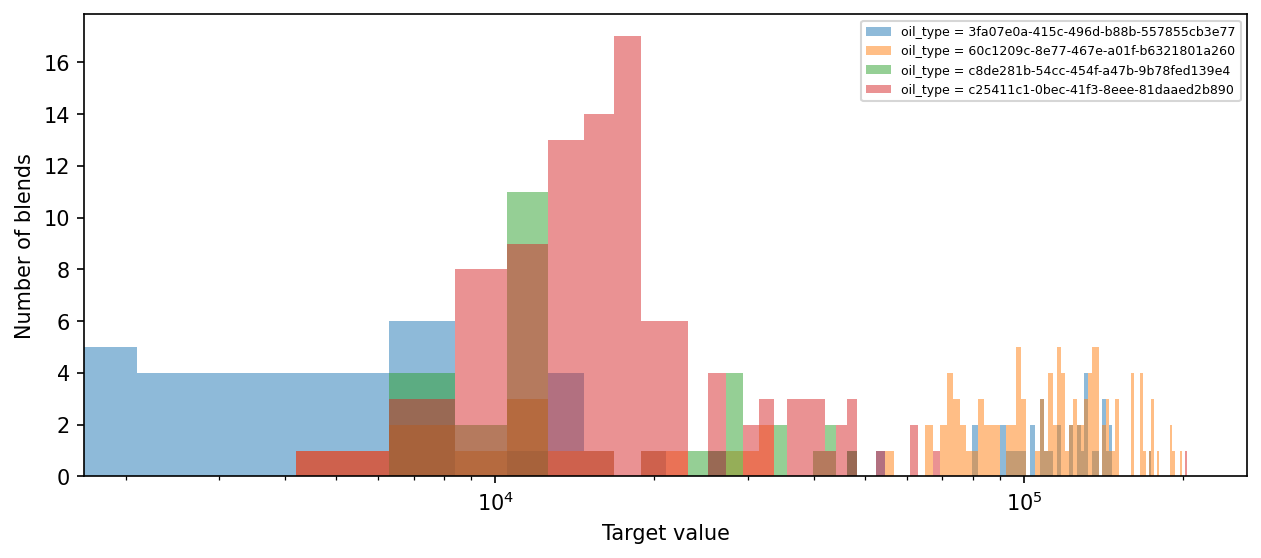

In [16]:
plt.figure(figsize=(10, 4), dpi=150)

for oil_type in oil_types[:-1]:
    values = data_df[(data_df.oil_type == oil_type) & (data_df.oil_property_param_title == target_oil_property)].groupby(['blend_id']).oil_property_param_value.mean().to_numpy()
    plt.hist(values, bins=100, label=f'oil_type = {oil_type}', alpha=0.5, density=False, range=(0, 2.1e5))

plt.xscale('log')
plt.legend(loc='best', prop = { "size": 6 })
plt.xlabel('Target value'); plt.ylabel('Number of blends')
plt.show()

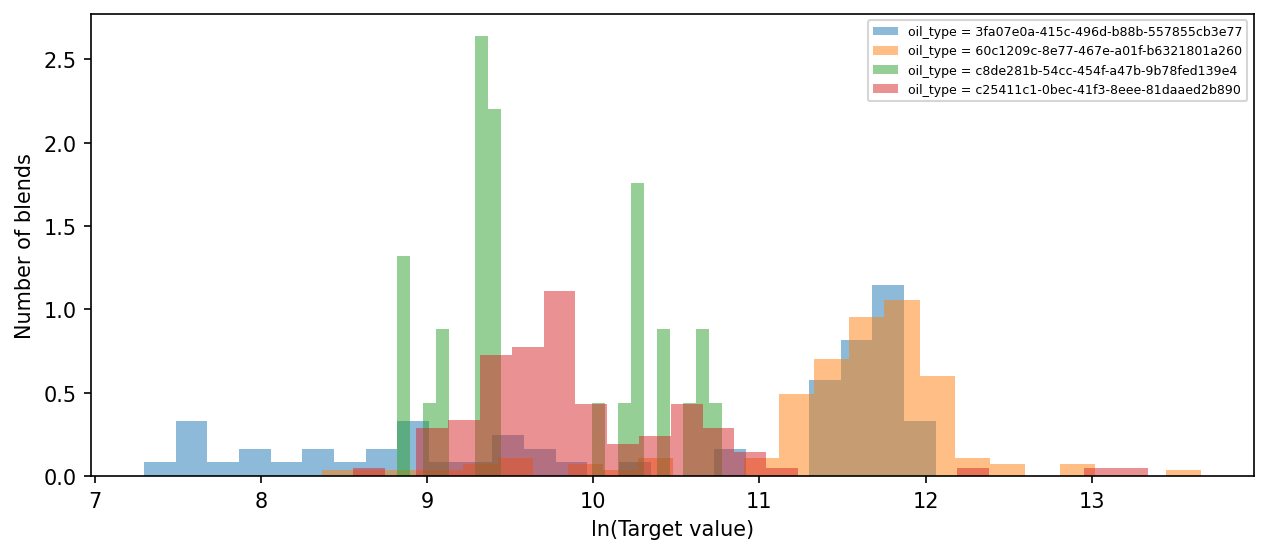

In [17]:
plt.figure(figsize=(10, 4), dpi=150)

for oil_type in oil_types[:-1]:
    values = data_df[(data_df.oil_type == oil_type) & (data_df.oil_property_param_title == target_oil_property)].groupby(['blend_id']).oil_property_param_value.mean().to_numpy()
    values = np.log(values)
    plt.hist(values, bins=25, label=f'oil_type = {oil_type}', alpha=0.5, density=True)#, range=(0, 2.1e5))

plt.legend(loc='best', prop = { "size": 6 })
plt.xlabel('ln(Target value)'); plt.ylabel('Number of blends')
plt.show()

### Feature Selection: Oil Properties

In [18]:
# Filtering out useless oil properties: 
# those with only one unique value (or value + NaN, or all NaN)
# Such features provide no predictive power for classification

uniques = data_df.groupby('oil_property_param_title').oil_property_param_value.unique()
uniques = uniques[uniques.map(len) <= 2]

In [19]:
is_useless = uniques.apply(lambda x: len(np.isfinite(x)) < 2)
useless_oil_props = list(is_useless[is_useless == True].index)
len(useless_oil_props)

20

In [20]:
oil_props = set(data_df.oil_property_param_title.unique()) - set(useless_oil_props)
len(oil_props)

84

In [21]:
num2oiltype = {
    0: '3fa07e0a-415c-496d-b88b-557855cb3e77',
    1: '60c1209c-8e77-467e-a01f-b6321801a260',
    2: 'c8de281b-54cc-454f-a47b-9b78fed139e4',
    3: 'c25411c1-0bec-41f3-8eee-81daaed2b890'
}

oiltype2num = {num2oiltype[num]:num for num in num2oiltype}

In [22]:
# Hypothesis: Each oil type has its own set of relevant oil properties
# We identify oil properties specific to each oil type:
# An oil properties is considered relevant if defined for >30% of blends of that type

oilprop2types = dict()
# example: oilprop2types[oil_prop] = [0, 1, 0, 0] 
# -> oil_prop is considered important for oil_type = num2oiltype[1]
# (note: num2oiltype uses 0-based indexing)

for oil_prop in tqdm(oil_props):
    oilprop2types[oil_prop] = [0, 0, 0, 0]
    for oil_type, typenum in oiltype2num.items():
        vals = data_df[(data_df.oil_type == oil_type) & (data_df.oil_property_param_title == oil_prop)].groupby('blend_id')
        count_blends = len(vals)
        std = vals.oil_property_param_value.mean().std()
        mean = vals.oil_property_param_value.mean().mean()
        count_blends_all = len(data_df[(data_df.oil_type == oil_type)].groupby('blend_id'))

        if count_blends/count_blends_all > 0.3: oilprop2types[oil_prop][typenum] = 1

  0%|          | 0/84 [00:00<?, ?it/s]

In [23]:
# Remove oil_props that are undefined (<=30% prevalence) for all oil_types from oilprop2types

for oil_prop in list(oil_props):
    if max(oilprop2types[oil_prop]) == 0: 
        oil_props.remove(oil_prop)
        
len(oil_props)

16

In [24]:
# We should remove target from features

print(target_oil_property in oil_props)
oil_props.remove(target_oil_property)

True


In [25]:
# These 15 oil properties are considered significant

for oil_prop in oil_props:
    print(oil_prop, oilprop2types[oil_prop], sep='\t')

161776ad-2131-4557-a1f2-995bacb90bf0	[0, 1, 1, 0]
4c7a51f1-dc82-41dc-92fa-772535c2c70c	[1, 1, 1, 1]
5cf8e492-dfea-4ecb-8799-a97989c46256	[0, 1, 0, 0]
7fde038e-937b-4420-a4de-daf51b2ab54a	[0, 1, 1, 0]
9fa62975-847a-469e-bd3e-e0e133141ab0	[0, 0, 0, 1]
33fd9876-db06-478c-8993-17dd5d9d698a	[1, 1, 1, 1]
e238dd99-a730-4333-9ef0-85a3faaa4ff0	[0, 0, 1, 0]
9e2de643-ddca-487e-b9e7-69b25d8662bf	[0, 1, 0, 0]
50d7e65f-df1c-4e73-8961-9608846cf1d3	[0, 0, 1, 0]
c97c9cdb-a28a-499d-9da3-e769290b05d7	[0, 0, 1, 0]
7c8a81df-b7e7-4507-aab1-79a61fce7887	[0, 1, 1, 1]
5f1a9612-c626-4f94-8e98-6a103e4f07ef	[0, 1, 0, 0]
7fa1099c-cc3d-4bc2-ab0b-daa4fce8002e	[0, 0, 1, 0]
d7651afb-daba-4d99-bab9-ec17ae0f30ca	[0, 0, 0, 1]
9e87f31b-a049-464c-bc75-fd17bb9b98b0	[1, 0, 0, 0]


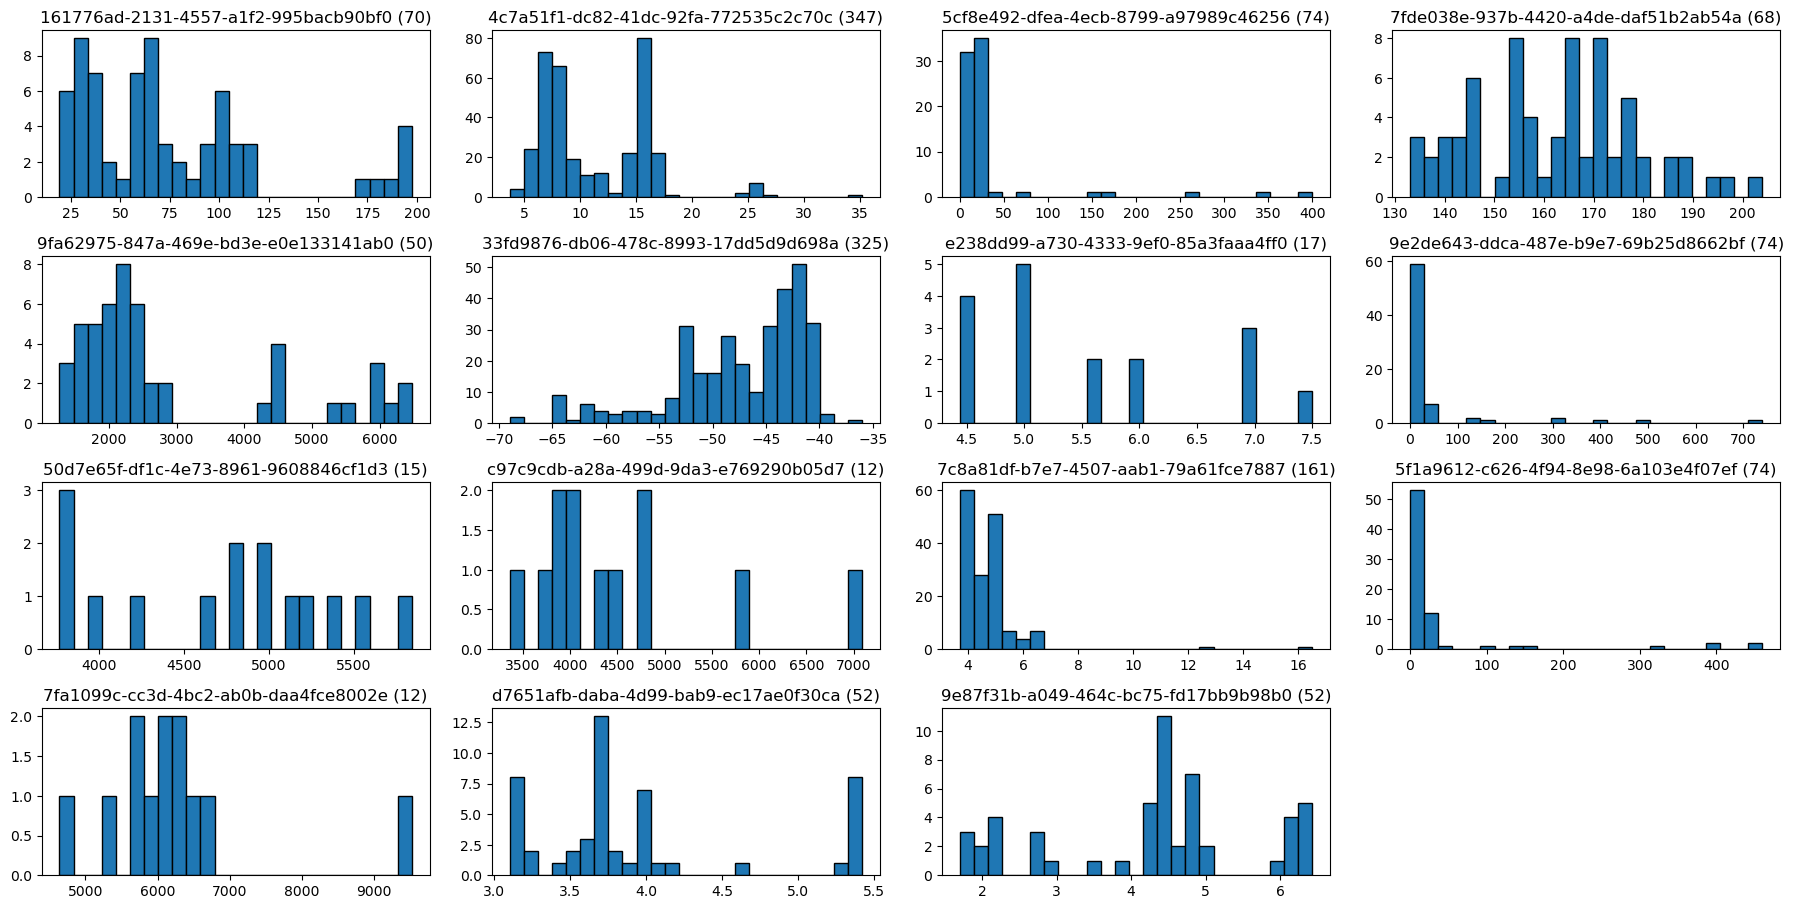

In [26]:
# Distributions of these oil properties

plt.figure(figsize=(18, 18))
i = 1
for oil_prop in oil_props:
    plt.subplot(8, 4, i)
    i += 1
    vals = data_df[data_df.oil_property_param_title == oil_prop].groupby('blend_id').oil_property_param_value.mean().values
    plt.hist(vals, bins=25, edgecolor='k')
    plt.title(f'{oil_prop} ({len(vals)})')
    
    
plt.tight_layout()
plt.show()

In [27]:
# Pre-calculate median oil property values:
# - For each oil_type: median per property
# - For NaN oil_type: global median

mean_oilprops = dict()

oil_types = list(oiltype2num.keys())
for oil_prop in tqdm(oil_props):
    vals = data_df[(data_df.oil_property_param_title == oil_prop) & np.isfinite(data_df.oil_property_param_value)].groupby('blend_id').oil_property_param_value.mean()
    
    valfull = np.median(vals)
    for oil_type in oil_types:
        vals = data_df[(data_df.oil_property_param_title == oil_prop) & np.isfinite(data_df.oil_property_param_value) & (data_df.oil_type == oil_type)].groupby('blend_id').oil_property_param_value.mean()
        if len(vals) == 0: # если у данного oil type нет этого oil prop вообще, то берем значение по всему
            mean_oilprops[(oil_prop, oil_type)] = valfull
        else:
            val = np.median(vals)
            mean_oilprops[(oil_prop, oil_type)] = val

    mean_oilprops[(oil_prop, '')] = valfull

  0%|          | 0/15 [00:00<?, ?it/s]

In [28]:
oil_props = list(oil_props)
pickle.dump(oil_props, open('model/oil_props', 'wb'))
pickle.dump(mean_oilprops, open('model/mean_oilprops', 'wb'))

### Feature Selection: Component Properties

In [29]:
# For >50% of components, critical information is missing:
# - component class
# - SMILES strings
# - polymer status
# However, some component properties are available

print(len(data_df[data_df.polymer.isnull()].component_name.unique()), end='\n\n')
print((~data_df[data_df.polymer.isnull()][['polymer', 'component_class', 'smiles', 'component_property_param_title', 'component_property_param_value']].isnull()).sum())

61

polymer                                0
component_class                        0
smiles                                 0
component_property_param_title    115732
component_property_param_value     23197
dtype: int64


In [35]:
# Filtering out useless component properties:
# - Constant numeric values (all same number)
# - All NaN values
# - Single number + NaN cases
# These provide no predictive value (zero variance)

uniques = data_df.groupby('component_property_param_title').component_property_param_value.unique()
uniques = uniques[uniques.map(len) <= 2]  # comp props that have 2 or less uniuque values (1 could be NaN)

In [36]:
is_useless = uniques.apply(lambda x: (len(x) == 1) | np.any(np.isnan(x)) )  
useless_comp_props = list(is_useless[is_useless == True].index)
len(useless_comp_props)

40

In [32]:
comp_props = list(set(data_df.component_property_param_title.unique()) - set(useless_comp_props))
len(comp_props)

23

In [33]:
# Note: polymer/non-polymer status is fully encoded in component_class,
# the sets are disjoint (no overlap between polymer/non-polymer classes)

print(list(data_df[data_df.polymer == 'no'].component_class.unique()))
print(list(data_df[data_df.polymer == 'yes'].component_class.unique()))

['Group 1 base oil', 'Group 3 base oil', 'Group 2 base oil', 'Corrosion Inhibitor', 'Detergent Additive', 'Antioxidant Additive', 'Dispersant Additive']
['Pour Point Depressant', 'Viscosity Index Improver', 'Group 5 base oil', 'Group 4 base oil', 'Additive', 'Friction Modifier']


  0%|          | 0/23 [00:00<?, ?it/s]

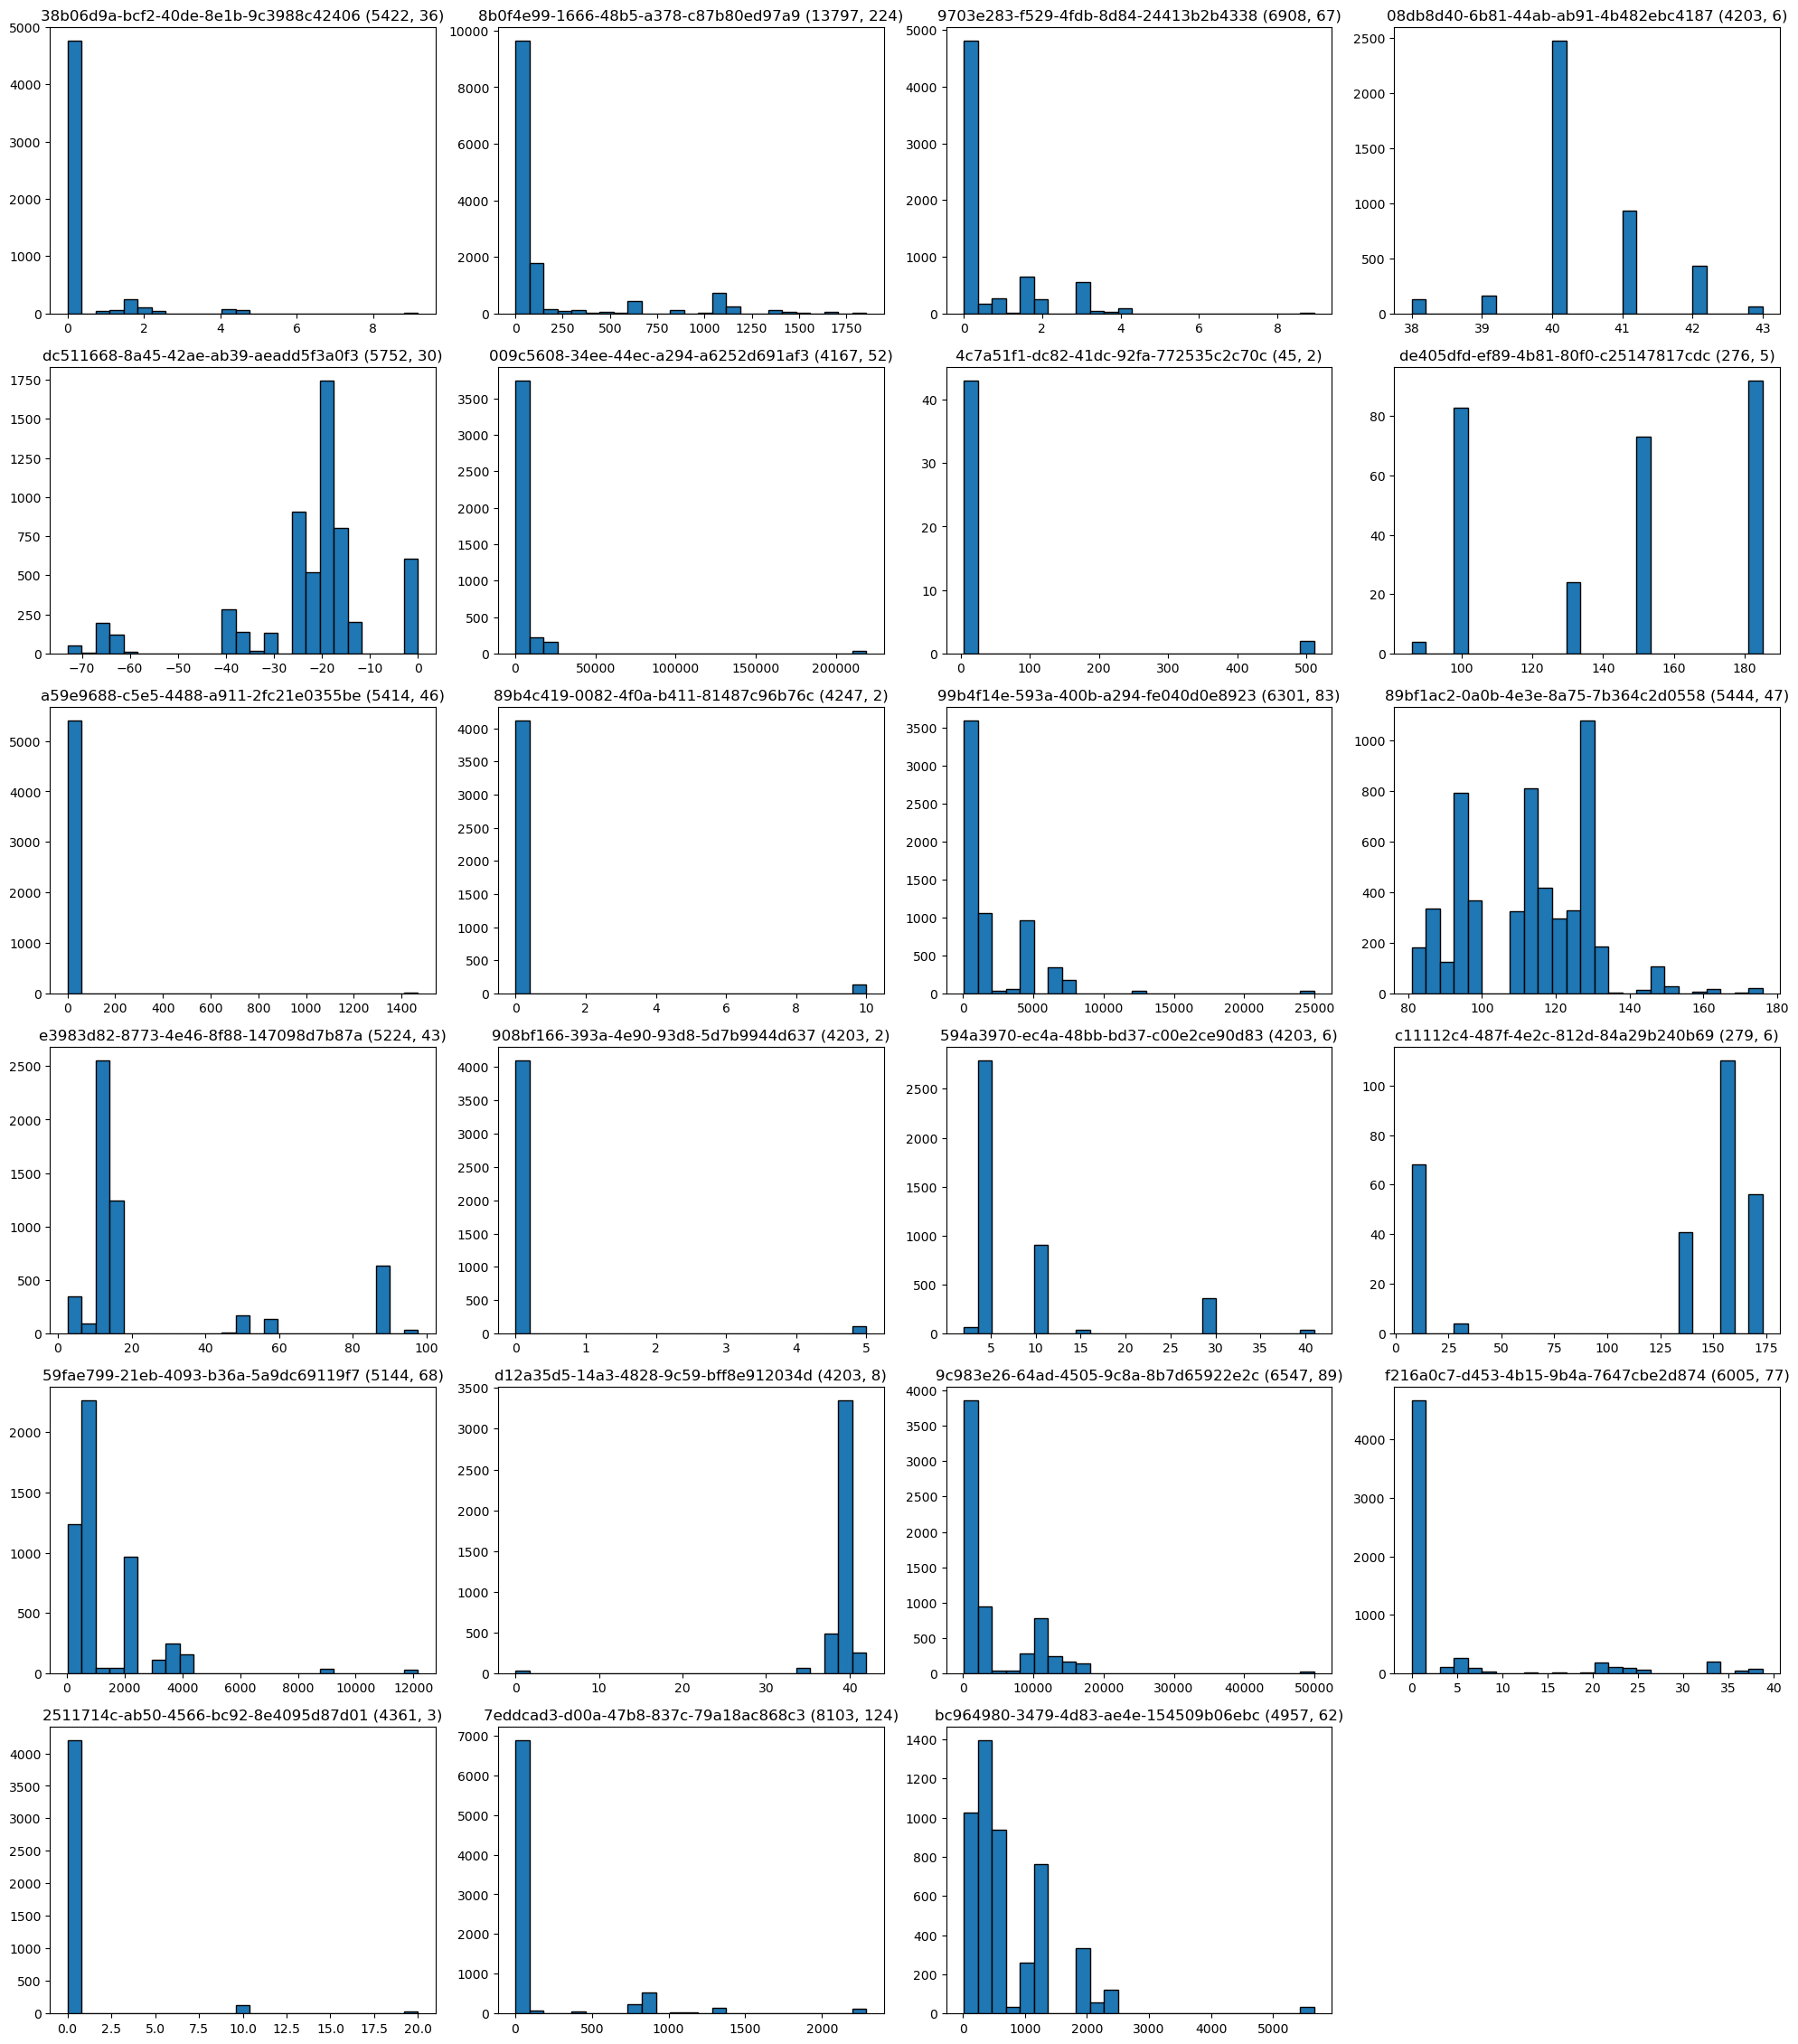

In [37]:
# Distributions of selected component properties

plt.figure(figsize=(20, 30))
i = 1
for comp_prop in tqdm(comp_props):
    plt.subplot(8, 4, i)
    i += 1
    vals = data_df[(data_df.component_property_param_title==comp_prop) & np.isfinite(data_df.component_property_param_value)].groupby(['blend_id', 'oil_property_param_title', 'component_name']).component_property_param_value.mean().values
    plt.hist(vals, bins=25, edgecolor='k')
    plt.title(f'{comp_prop} {len(vals), len(np.unique(vals))}')
    
    
plt.tight_layout()
plt.show()

In [38]:
# The following component properties appear to contain outliers: 
#   009c5608-34ee-44ec-a294-a6252d691af3
#   9c983e26-64ad-4505-9c8a-8b7d65922e2c
#   a59e9688-c5e5-4488-a911-2fc21e0355be
# Analyzing value distributions per component_class

for comp_prop in ['009c5608-34ee-44ec-a294-a6252d691af3', '9c983e26-64ad-4505-9c8a-8b7d65922e2c', 'a59e9688-c5e5-4488-a911-2fc21e0355be']:
    print(comp_prop)
    for comp_class in sorted(data_df[~data_df.component_class.isnull()].component_class.unique()):
        vals = data_df[(data_df.component_class == comp_class) & np.isfinite(data_df.component_property_param_value) & (data_df.component_property_param_title == comp_prop)].component_property_param_value.unique()
        if len(vals) == 0: continue
        print(comp_class, vals)
    
    vals = data_df[data_df.component_class.isnull() & np.isfinite(data_df.component_property_param_value) & (data_df.component_property_param_title == comp_prop)].component_property_param_value.unique()
    if len(vals) != 0: print('nan', vals)
    print()

009c5608-34ee-44ec-a294-a6252d691af3
Additive [2509. 2599.]
Group 1 base oil [21000.  2906. 22000.]
Group 2 base oil [  200.   924. 12294.   818. 11736.   835.]
Group 3 base oil [ 3075.  3112.  4479.  2869. 15217.  2866.  4328.  3224.  3121.  3819.
  3064.  2539.  4211.  2771.  4892.  3030.  2993.  4187.  3170.  4359.
  2841.  1645.  2870.  4530.  3279.  4335.  3010.  5642.  2950.  2743.
  4943.  4614.  3086.  4171.  3166.]
Group 4 base oil [  1446.   1431. 219017.   5717.   1494.]
Group 5 base oil [200.]
nan [ 200. 2896.]

9c983e26-64ad-4505-9c8a-8b7d65922e2c
Additive [1445. 1544.]
Group 1 base oil [10407.  9680. 10565. 10573. 10272. 10745.  9928.  1466. 10923.  9446.
 50000. 10045. 10814.  9777. 10861. 10684. 10847.]
Group 2 base oil [  100.    99. 11692.   540. 14175. 14010. 12289.  6212. 15184.   466.
 14605.  5912. 17000. 15055.   380. 14123.   480. 14001.]
Group 3 base oil [1694. 2309. 1750. 2377. 1584. 2633. 1574. 2340. 1737. 1717. 2063. 1671.
 1397. 2243. 1972. 1523. 2329. 2594

In [39]:
data_df.loc[(data_df.component_property_param_value == 1469) & 
            (data_df.component_property_param_title == 'a59e9688-c5e5-4488-a911-2fc21e0355be'), 'component_property_param_value'] = np.nan

data_df.loc[(data_df.component_property_param_value == 50000) & 
            (data_df.component_property_param_title == '9c983e26-64ad-4505-9c8a-8b7d65922e2c'), 'component_property_param_value'] = np.nan

data_df.loc[(data_df.component_property_param_value == 219017) & 
            (data_df.component_property_param_title == '009c5608-34ee-44ec-a294-a6252d691af3'), 'component_property_param_value'] = np.nan

In [40]:
# Pre-calculate median component property values:
# - For each polymer status: median per property
# - For NaN polymer status: global median

mean_compprops = dict()

for comp_prop in tqdm(comp_props):
    vals = data_df[(data_df.component_property_param_title == comp_prop) & np.isfinite(data_df.component_property_param_value)].groupby(['blend_id', 'component_name', 'component_property_param_title']).component_property_param_value.mean()
    valfull = np.median(vals)
    
    # polym
    vals = data_df[(data_df.polymer == 'yes') & (data_df.component_property_param_title == comp_prop) & np.isfinite(data_df.component_property_param_value)].groupby(['blend_id', 'component_name', 'component_property_param_title']).component_property_param_value.mean()
    if len(vals) == 0:
        mean_compprops[(comp_prop, 'yes')] = valfull
    else:
        val = np.median(vals)
        mean_compprops[(comp_prop, 'yes')] = val
    
    # nopolym
    vals = data_df[(data_df.polymer == 'no') & (data_df.component_property_param_title == comp_prop) & np.isfinite(data_df.component_property_param_value)].groupby(['blend_id', 'component_name', 'component_property_param_title']).component_property_param_value.mean()
    if len(vals) == 0:
        mean_compprops[(comp_prop, 'no')] = valfull
    else:
        val = np.median(vals)
        mean_compprops[(comp_prop, 'no')] = val
    
    # nanpolym
    vals = data_df[pd.isna(data_df.polymer) & (data_df.component_property_param_title == comp_prop) & np.isfinite(data_df.component_property_param_value)].groupby(['blend_id', 'component_name', 'component_property_param_title']).component_property_param_value.mean()
    if len(vals) == 0:
        mean_compprops[(comp_prop, '')] = valfull
    else:
        val = np.median(vals)
        mean_compprops[(comp_prop, '')] = val

  0%|          | 0/23 [00:00<?, ?it/s]

In [41]:
pickle.dump(comp_props, open('model/comp_props', 'wb'))
pickle.dump(mean_compprops, open('model/mean_compprops', 'wb'))

## Feature Engineering

In [42]:
comptype2num = {'Group 1 base oil': 0,
                'Group 2 base oil': 1,
                'Group 3 base oil': 2,
                'Group 4 base oil': 3,
                'Group 5 base oil': 4,
                'Additive': 5,
                'Antioxidant Additive': 6,
                'Corrosion Inhibitor': 7,
                'Detergent Additive': 8,
                'Dispersant Additive': 9,
                'Friction Modifier': 10,
                'Pour Point Depressant': 11,
                'Viscosity Index Improver': 12}

In [43]:
pickle.dump(comptype2num, open('model/comptype2num', 'wb'))

### SMILES Embeddings Generation

In [44]:
unique_smiles = list(data_df.smiles[~data_df.smiles.isnull()].unique())
print(f'Number of unique SMILES: {len(unique_smiles)}')

Number of unique SMILES: 51


In [45]:
elements = ['O', 'H', 'Cl', 'C']

In [46]:
embeddings = []

for smiles in tqdm(unique_smiles):    
    mol = Chem.MolFromSmiles(smiles)
    mol_h = Chem.AddHs(mol)

    num_atoms = mol_h.GetNumAtoms()
    num_heavy = mol_h.GetNumHeavyAtoms()
    num_atomatic = len(mol_h.GetAromaticAtoms())
    mol_elements = list(map(lambda x: x.GetSymbol(), mol_h.GetAtoms()))

    x = [num_atoms, num_heavy, num_atomatic]
    for element in elements:
        if element in mol_elements:
            x.append(mol_elements.count(element))
        else:
            x.append(0)

    AllChem.EmbedMolecule(mol_h, useRandomCoords=True)
    try:
        AllChem.MMFFOptimizeMolecule(mol_h, maxIters=10000)
    except ValueError:
        pass

    num_acceptors = Chem.rdMolDescriptors.CalcNumHBA(mol_h)
    num_donors = Chem.rdMolDescriptors.CalcNumHBD(mol_h)
    tpsa = Chem.rdMolDescriptors.CalcTPSA(mol_h)
    vol = AllChem.ComputeMolVolume(mol_h,gridSpacing=0.1)
    x.append(num_acceptors)
    x.append(num_donors)
    x.append(tpsa)
    x.append(vol)
    
    embeddings.append(x)

embeddings = np.array(embeddings)

  0%|          | 0/51 [00:00<?, ?it/s]

[18:49:25] UFFTYPER: Unrecognized atom type: Ca1+2 (13)
[18:49:33] UFFTYPER: Warning: hybridization set to SP3 for atom 2
[18:49:33] UFFTYPER: Unrecognized charge state for atom: 4
[18:49:33] UFFTYPER: Unrecognized atom type: Zn2+2 (4)
[18:49:33] UFFTYPER: Warning: hybridization set to SP3 for atom 6


In [47]:
smiles2embedding = {unique_smiles[i] : embeddings[i] for i in range(len(unique_smiles))}

In [48]:
# Mixture embedding strategy:
# - Average of component embeddings (when SMILES available)
# - Database-wide mean embedding (no valid SMILES)

base_embed = np.zeros(embeddings.shape[1])
all_smiles, all_count = np.unique(np.concatenate(data_df[~data_df.smiles.isnull()].groupby(['blend_id']).smiles.unique().values), return_counts=True)
for smiles, count in zip(all_smiles, all_count):
    base_embed += smiles2embedding[smiles] * count / all_count.sum()

In [49]:
np.save('model/base_embed.npy', base_embed)

### Feature Construction

In [50]:
# one-hot oil type

oiltype2vec = {oiltype: [0, 0, 0, 0] for oiltype in oiltype2num}
for oil_type in oiltype2num:
    oiltype2vec[oil_type][oiltype2num[oil_type]] = 1

In [51]:
pickle.dump(oiltype2vec, open('model/oiltype2vec', 'wb'))

In [52]:
blend_ids = []
Xs = []
ys = []

for blend_id in tqdm(list(data_df.blend_id.unique())):
    target_list = data_df[(data_df.blend_id == blend_id) & (data_df.oil_property_param_title == target_oil_property)].groupby('blend_id').oil_property_param_value.mean().values
    if len(target_list) == 0: continue
    target = target_list[0]
    
    blend_ids.append(blend_id)
    ys.append(target)
    
    feature_vector = []

    # oil type (one-hot) -> 4-dimensional vector
    oiltype_list = data_df[data_df.blend_id == blend_id].oil_type.unique()
    assert len(oiltype_list) == 1, 'Several oil types for one blend'
    oil_type = oiltype_list[0]
    
    try: oiltype_vec = oiltype2vec[oil_type]
    except: oiltype_vec = [1/4]*4
    feature_vector += oiltype_vec

    # oil props -> 15-dimensional vector
    oilprops_vec = []
    assert max(data_df[data_df.blend_id == blend_id].groupby('oil_property_param_title').oil_property_param_value.unique().apply(lambda x: len(x)).values) == 1 # ?
    oilprop2val = data_df[(data_df.blend_id == blend_id) & np.isfinite(data_df.oil_property_param_value)].groupby('oil_property_param_title').oil_property_param_value.mean().to_dict()
    
    for oil_prop in oil_props:
        try: oilprops_vec += [oilprop2val.get(oil_prop, mean_oilprops[(oil_prop, oil_type)])]
        except: oilprops_vec += [oilprop2val.get(oil_prop, mean_oilprops[(oil_prop, '')])]
    feature_vector += oilprops_vec
    
    # component types (bag of words) -> 13-dimensional vector
    comp_type_bow = [0]*13
    blend_comp_types = list(data_df[data_df.blend_id == blend_id].groupby('component_name').component_class.min().values)
    
    for comp_type in blend_comp_types:
        try: comp_type_bow[comptype2num[comp_type]] += 1
        except:
            for i in range(13):
                comp_type_bow[i] += 1/13
    feature_vector += comp_type_bow

    # component properties -> 23-dimensional vector
    comp_val_list = []
    blend_comp_names = data_df[(data_df.blend_id == blend_id)].groupby(['component_name']).component_name.min().values
    for comp_name in blend_comp_names:
        compprop2val = data_df[(data_df.blend_id == blend_id) & (data_df.component_name == comp_name) & np.isfinite(data_df.component_property_param_value)].groupby('component_property_param_title').component_property_param_value.mean().to_dict()
        tmp = data_df[(data_df.blend_id == blend_id) & (data_df.component_name == comp_name)].polymer.unique()
        assert len(tmp) == 1
        if isinstance(tmp[0], str): polymer = tmp[0]
        else: polymer = ''
        
        comp_val_list.append([])
        for comp_prop in comp_props:
            comp_val_list[-1].append(compprop2val.get(comp_prop, mean_compprops[(comp_prop, polymer)]))
    feature_vector += list(np.array(comp_val_list).mean(axis=0))
    
    # smiles rdkit embeds -> 11-dimensional vector
    smiles_embed_list = []
    smiles_num = (~data_df[(data_df.blend_id == blend_id)].groupby('component_name').smiles.min().isnull()).sum()
    if smiles_num == 0:
        smiles_embed_list = [base_embed]
    else:
        smiles_list = list(data_df[(data_df.blend_id == blend_id)].groupby('component_name').smiles.min().values)
        for smiles in smiles_list:
            if isinstance(smiles, str):
                smiles_embed_list.append(smiles2embedding[smiles])
    feature_vector += list(np.array(smiles_embed_list).mean(axis=0))
    
    Xs.append(feature_vector)

Xs = np.array(Xs)
ys = np.array(ys)

  0%|          | 0/348 [00:00<?, ?it/s]

In [53]:
# Viscosity should be positive

Xs = Xs[ys>0]
ys = ys[ys>0]

print(Xs.shape, ys.shape)

(340, 66) (340,)


## Model Selection

In [54]:
def exp_mae_fun(X1, X2):
    return np.abs(np.exp(X1) - np.exp(X2)).mean()

exp_mae_error = make_scorer(exp_mae_fun, greater_is_better=False)

def exp_rmae_fun(X1, X2):
    return (np.abs(np.exp(X1) - np.exp(X2))/np.abs(np.exp(X1))).mean()

exp_rmae_error = make_scorer(exp_rmae_fun, greater_is_better=False)

def exp_rmse_fun(X1, X2):
    return np.sqrt(np.square(np.exp(X1) - np.exp(X2)).mean())

exp_rmse_error = make_scorer(exp_rmse_fun, greater_is_better=False)

#### Decision Tree

In [58]:
param_grid = { 
    "criterion"         : ['squared_error', 'absolute_error'],
    "max_depth"         : [None, 15, 30, 50, 75, 100],
    "max_features"      : [None, 'sqrt'],

}

model = DecisionTreeRegressor(random_state=42)

grid = GridSearchCV(model, param_grid, scoring=exp_mae_error, n_jobs=-1, cv=5, refit=True, verbose=1)
grid.fit(Xs, np.log(ys))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [None, 15, 30, 50, 75, 100],
                         'max_features': [None, 'sqrt']},
             scoring=make_scorer(exp_mae_fun, greater_is_better=False),
             verbose=1)

In [59]:
model = grid.best_estimator_
print(-grid.best_score_, grid.best_params_, sep='\n')

22974.249010041112
{'criterion': 'absolute_error', 'max_depth': 15, 'max_features': None}


In [60]:
scores = -cross_val_score(model, Xs, np.log(ys), scoring=exp_mae_error, cv=5)
print(scores)
print(scores.mean(), scores.std())

[26498.61901988 26177.17904955 21754.53187644 24341.62279112
 16099.29231322]
22974.249010041112 3828.900503556195


In [61]:
scores = -cross_val_score(model, Xs, np.log(ys), scoring=exp_rmse_error, cv=5)
print(scores)
print(scores.mean(), scores.std())

[79914.40121857 91745.28895874 32853.80900111 77478.49501918
 32618.86681713]
62922.17220294454 25114.900849142574


#### Random Forest

In [62]:
param_grid = { 
    "n_estimators"      : [500, 800, 900, 1000, 1100, 1200, 1500],
    "criterion"         : ['squared_error', 'absolute_error'],
    "max_features"      : [None, 'sqrt', 'log2'],
    "max_depth"         : [None, 10, 25, 50],
}

model = RandomForestRegressor(random_state=42, bootstrap=True)

grid = GridSearchCV(model, param_grid, scoring=exp_mae_error, n_jobs=-1, cv=5, refit=True, verbose=1)
grid.fit(Xs, np.log(ys))

Fitting 5 folds for each of 168 candidates, totalling 840 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [None, 10, 25, 50],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': [500, 800, 900, 1000, 1100, 1200,
                                          1500]},
             scoring=make_scorer(exp_mae_fun, greater_is_better=False),
             verbose=1)

In [67]:
model = grid.best_estimator_
print(-grid.best_score_, grid.best_params_, sep='\n')

18117.01332539736
{'criterion': 'absolute_error', 'max_depth': None, 'max_features': None, 'n_estimators': 1500}


In [65]:
scores = -cross_val_score(model, Xs, np.log(ys), scoring=exp_mae_error, cv=5)
print(scores)
print(scores.mean(), scores.std())

[25451.73206432 20565.48000934 13182.96599784 16453.61446534
 14931.27409015]
18117.01332539736 4405.763074765702


In [66]:
scores = -cross_val_score(model, Xs, np.log(ys), scoring=exp_rmse_error, cv=5)
print(scores)
print(scores.mean(), scores.std())

[86621.73182648 73207.40275323 18344.57909348 57524.74942715
 30090.41223344]
53157.775066755035 25631.840665098265


#### Gradient Boosting

In [68]:
param_grid = { 
    "n_estimators"      : [500, 750, 1000, 1250, 1500],
    "learning_rate"     : [0.1000, 0.0500, 0.0100, 0.0050, 0.0010, 0.0005],
    "max_depth"         : [None, 10, 25, 50],
}

model = GradientBoostingRegressor(loss='absolute_error', random_state=42)
grid = GridSearchCV(model, param_grid, scoring=exp_mae_error, n_jobs=-1, cv=5, refit=True, verbose=1)
grid.fit(Xs, np.log(ys))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='absolute_error',
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001,
                                           0.0005],
                         'max_depth': [None, 10, 25, 50],
                         'n_estimators': [500, 750, 1000, 1250, 1500]},
             scoring=make_scorer(exp_mae_fun, greater_is_better=False),
             verbose=1)

In [69]:
model = grid.best_estimator_
print(-grid.best_score_, grid.best_params_, sep='\n')

16527.311826339224
{'learning_rate': 0.01, 'max_depth': None, 'n_estimators': 1000}


In [70]:
scores = -cross_val_score(model, Xs, np.log(ys), scoring=exp_mae_error, cv=5)
print(scores)
print(scores.mean(), scores.std())

[24938.10826291 16311.75408818 11856.71947813 16993.85930342
 12536.11799905]
16527.311826339224 4663.682867316256


In [71]:
scores = -cross_val_score(model, Xs, np.log(ys), scoring=exp_rmse_error, cv=5)
print(scores)
print(scores.mean(), scores.std())

[86729.42798617 69094.70508842 16426.95855436 58932.96724969
 27124.88719005]
51661.78921373926 26191.86410896714


## Train

In [91]:
# Best model parameters

model = GradientBoostingRegressor(loss='absolute_error', random_state=42, max_depth=None, 
                                  n_estimators=1000, learning_rate=0.01, max_features=None)
model.fit(Xs, np.log(ys))

GradientBoostingRegressor(learning_rate=0.01, loss='absolute_error',
                          max_depth=None, n_estimators=1000, random_state=42)

In [92]:
joblib.dump(model, 'model/model.joblib')

['model/model.joblib']

In [93]:
ys_pred = np.exp(model.predict(Xs))

In [94]:
with open('results/train_preds.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['blend_id', 'y_real', 'y_pred'])
    for blend_id, y_real, y_pred in zip(blend_ids, ys, ys_pred):
        writer.writerow([blend_id, y_real, y_pred])

In [95]:
coefficient_of_dermination = r2_score(np.log(ys), np.log(ys_pred))
print(f'{coefficient_of_dermination:.3f}')

0.991


## Influence of Feature Groups

In [106]:
print(f'MAE 0: {np.abs(ys-ys.mean()).mean()}')

MAE 0: 59108.265536332176


In [107]:
# Keep only oil types 

scores = -cross_val_score(model, Xs[:, :4], np.log(ys), scoring=exp_mae_error, cv=5)
print(f'MAE 1: {scores.mean():.0f} {scores.std():.0f}')

MAE 1: 37741 9141


In [108]:
# Oil type with oil properties

scores = -cross_val_score(model, Xs[:, :19], np.log(ys), scoring=exp_mae_error, cv=5)
print(f'MAE 2: {scores.mean():.0f} {scores.std():.0f}')

MAE 2: 20949 4129


In [109]:
# Oil type, oil properties, and component classes

scores = -cross_val_score(model, Xs[:, :32], np.log(ys), scoring=exp_mae_error, cv=5)
print(f'MAE 3: {scores.mean():.0f} {scores.std():.0f}')

MAE 3: 18212 4401


In [110]:
# Oil type, oil properties, component classes, and component properties

scores = -cross_val_score(model, Xs[:, :55], np.log(ys), scoring=exp_mae_error, cv=5)
print(f'MAE 4: {scores.mean():.0f} {scores.std():.0f}')

MAE 4: 17686 4490


In [111]:
# Full (All previous features and SMILES embeddings)

scores = -cross_val_score(model, Xs, np.log(ys), scoring=exp_mae_error, cv=5)
print(f'MAE 5: {scores.mean():.0f} {scores.std():.0f}')

MAE 5: 16527 4664
